In [11]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload
from scipy.linalg import solve_banded
reload(plt)
%matplotlib notebook

from numba import njit
from scipy.linalg import solve_banded

In [12]:
def u(x, y ,t):
    return (1 + x * y + ((np.exp(t) - np.exp((-np.pi ** 2)*t)) / (1 + np.pi ** 2)) 
            * np.cos(np.pi * x / 2) * np.sin(np.pi * y / 2))

def u_t_0(x, y):
    return 1 + x * y

def u_x_0(y, t):
    return 1 + (np.exp(t) - np.exp(-np.pi **2 *t)) * np.sin(np.pi * y / 2) / (1 + np.pi ** 2)

def u_y_0(x, t):
    return 1

def u_x_1(y, t):
    return 1 + y

def u_y_1(x, t):
    return 1 + x + (np.exp(t) - np.exp(-np.pi ** 2 * t)) * np.cos(np.pi * x / 2) / (1 + np.pi ** 2)


a = 2
def f(x, y, t):
    return np.exp(t) * np.cos(np.pi * x / 2) * np.sin(np.pi * y / 2)

In [86]:
def lambda2(xl, x, xr, h):
    return (xl + xr - x - x) / h / h 

def do_step1(layer, t, h, u_x_0, u_x_1, u_y_0, u_y_1, f_layer, a, A):
    layer_result = np.zeros(shape=layer.shape)
    N = math.ceil(1 / h) + 1;
    x = np.linspace(0, 1, N)
    
    layer_result[0, :] = u_x_0(x, t)
    layer_result[-1, :] = u_x_1(x, t)
    layer_result[:, 0] = u_y_0(x, t)
    layer_result[:, -1] = u_y_1(x, t)
    
    x = np.linspace(0, 1, N)
    xx, yy = np.meshgrid(x, x)
    
    for j in range(1, N - 1):
   
        b = layer[1:-1, j] + tau / 2 * (f_layer[1:-1, j] + a * lambda2(*layer[j-1 : j+2, j], h))
     
        b[0] += u_x_0(j * h, t) * a * tau / h / h / 2
        b[-1] += u_x_1(j * h, t) * a * tau / h / h / 2
        
        layer_result[1:-1, j] = solve_banded((1, 1), A, b)
        
    return layer_result

def do_step2(layer, t, h, u_x_0, u_x_1, u_y_0, u_y_1, f_layer, a, A):
    
    layer_result = np.zeros(shape=layer.shape)
    N = math.ceil(1 / h) + 1;
    x = np.linspace(0, 1, N)
    
    layer_result[0, :] = u_x_0(x, t)
    layer_result[-1, :] = u_x_1(x, t)
    layer_result[:, 0] = u_y_0(x, t)
    layer_result[:, -1] = u_y_1(x, t)
    
    x = np.linspace(0, 1, N)
    xx, yy = np.meshgrid(x, x)
    
    for i in range(1, N - 1):
   
        b = layer[i, 1:-1] + tau / 2 * (f_layer[i, 1:-1] + a * lambda2(*layer[i, i-1 : i+2], h))

        b[0] += u_x_0(i * h, t) * a * tau / h / h / 2
        b[-1] += u_x_1(i * h, t) * a * tau / h / h / 2
        
        layer_result[i, 1:-1] = solve_banded((1, 1), A, b)
        
    return layer_result
    

def solve_ADI(tau, h, u_t_0, u_x_0, u_x_1, u_y_0, u_y_1, f, a, T):
    N = math.ceil(1 / h) + 1;
    K = math.ceil(T / tau) + 1;
    
    x = np.linspace(0, 1, N)
    xx, yy = np.meshgrid(x, x)
    layer = u_t_0(xx, yy)
    
    A = np.zeros(shape=(3, N - 2))
    A[0, 1:] = - a * tau / 2 / h ** 2
    A[2, :-1] =  - a * tau / 2 / h ** 2
    A[1, :] = 1 + a * tau / h ** 2
    print(A)
    for k in range(1, K):
        t = k * tau;
        f_layer = f(xx, yy, t + tau / 2)
        layer_temp = do_step1(layer, t - tau / 2, h, u_x_0, u_x_1, u_y_0, u_y_1, f_layer, a, A)
        layer = do_step2(layer_temp, t, h, u_x_0, u_x_1, u_y_0, u_y_1, f_layer, a, A)
    
    return layer_temp

In [87]:
h = 0.1
tau = 0.1
T = 1

y = solve_ADI(tau, h, u_t_0, u_x_0, u_x_1, u_y_0, u_y_1, f, a, T)


[[  0. -10. -10. -10. -10. -10. -10. -10. -10.]
 [ 21.  21.  21.  21.  21.  21.  21.  21.  21.]
 [-10. -10. -10. -10. -10. -10. -10. -10.   0.]]


In [88]:
def plot(y, u, h, T, title):
    N = y.shape[1]
    X = h * np.arange(N)
    XX1, XX2 = np.meshgrid(X, X)

    Z = u(XX1, XX2, T)
    print(Z)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(XX1, XX2, Z, label='original solution"')
    surf._edgecolors2d= surf._edgecolors3d
    surf._facecolors2d= surf._facecolors3d
    
    #ax.scatter3D(XX1, XX2, y, c='Red', s=1, label='numerical solution');
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.set_title(title);
    ax.legend(loc ='lower right')

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.03912055 1.04863891 1.05720585 1.06485666 1.07164919 1.0776624
  1.08299448 1.08776036 1.09208891 1.0961198  1.1       ]
 [1.07727782 1.0963264  1.11349557 1.12885504 1.14251907 1.15464367
  1.16542276 1.17508339 1.18388016 1.19208891 1.2       ]
 [1.11353225 1.14213448 1.16797559 1.19115798 1.21184952 1.23027942
  1.24673258 1.26154256 1.27508339 1.28776036 1.3       ]
 [1.14699114 1.18518144 1.21979688 1.25097007 1.27891833 1.30393843
  1.32639923 1.34673258 1.36542276 1.38299448 1.4       ]
 [1.17683063 1.22465355 1.26817592 1.30755724 1.34305898 1.37503813
  1.40393843 1.43027942 1.45464367 1.4776624  1.5       ]
 [1.20231595 1.25982511 1.3124139  1.36026483 1.40367704 1.44305898
  1.47891833 1.51184952 1.54251907 1.57164919 1.6       ]
 [1.22281959 1.29007631 1.35191402 1.40853371 1.46026483 1.50755724
  1.55097007 1.59115798 1.62885504 1.66485666 1.7       ]
 

<IPython.core.display.Javascript object>


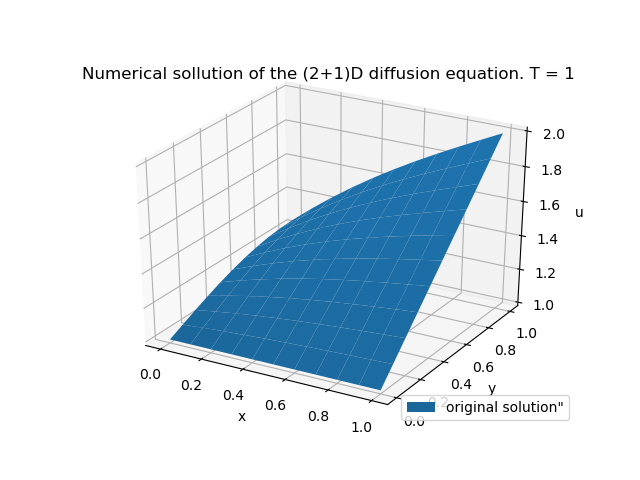

In [85]:
plot(y, u, h, T, "Numerical sollution of the (2+1)D diffusion equation. T = 1")